In [1]:
import tensorflow as tf 
import keras
import numpy as np
import pandas as pd
print(tf.__version__)
print(keras.__version__)
print(pd.__version__)
print(np.__version__)

from nn_globals import *
from dataset import muon_data_split
from nn_evaluate import k_fold_validation, huber_loss
import qkeras.utils as utils
from nn_training_pruned_model import generate_layer_masks
from nn_training import lr_schedule, train_model

from keras.layers import Layer, Input, BatchNormalization, Activation
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from keras import initializers, regularizers
from tensorflow.keras.constraints import Constraint
from keras.callbacks import LearningRateScheduler, EarlyStopping, TerminateOnNaN
from qkeras import *
from nn_evaluate import k_fold_validation
from nn_plotting import __generate_delta_plots__

2.6.0
2.6.0
1.3.4
1.19.5


In [2]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ= muon_data_split(infile_muon_displ, 
                                                                                                           reg_pt_scale=reg_pt_scale, 
                                                                                                           reg_dxy_scale=reg_dxy_scale, 
                                                                                                           test_size=0.315,
                                                                                                           batch_size = 128)


[INFO    ] Loading muon data from /Users/gpradhan/Desktop/optimization-for-cms-muon-trigger-nn/data/NN_input_params_FlatXYZ.npz ...
[INFO    ] Loaded the variables with shape (19300000, 25)
[INFO    ] Loaded the parameters with shape (19300000, 6)
[INFO    ] Loaded the encoded variables with shape (3284620, 23)
[INFO    ] Loaded the encoded parameters with shape (3284620,)
[INFO    ] Loaded # of training and testing events: (2249964, 1034656)
[WARNING ] The last batch for training could be too few! (2024967%128)=7. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*0.9) % 128
[WARNING ] The last batch for training after mixing could be too few! (4049935%128)=15. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*2*0.9) % 128


In [3]:
qkeras_file = "models/quantized_DNN_affine_BN_bits_8_int_4.h5"
weights_file = "models/quantized_DNN_affine_BN_bits_8_int_4"
loaded_qmodel = utils.load_qmodel(filepath=qkeras_file)
loaded_qmodel.load_weights(weights_file)

2021-12-28 15:10:45.391534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-28 15:10:45.391674: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [4]:
from qkeras.quantizers import *
from qkeras.quantizers import _get_integer_bits
from qkeras.quantizers import get_quantizer
from tensorflow_model_optimization.python.core.sparsity.keras.prunable_layer import PrunableLayer
from qkeras import Clip

class CustomQDense(Dense, PrunableLayer):
    """Implements a quantized Dense layer with masking."""
    
    # Following layer is a modification of the original QDense layer.
    # Base code inherited from [https://github.com/google/qkeras/blob/master/qkeras/qlayers.py#L544]
    # Most of these parameters follow the implementation of Dense in
    # Keras, with the exception of kernel_range, bias_range,
    # kernel_quantizer, bias_quantizer, and kernel_initializer.
    # kernel_quantizer: quantizer function/class for kernel
    # bias_quantizer: quantizer function/class for bias
    # kernel_range/bias_ranger: for quantizer functions whose values
    #   can go over [-1,+1], these values are used to set the clipping
    #   value of kernels and biases, respectively, instead of using the
    #   constraints specified by the user.
    # we refer the reader to the documentation of Dense in Keras for the
    # other parameters.

    def __init__(self,
               units,
               mask,
               activation=None,
               use_bias=False,
               kernel_initializer="he_normal",
               bias_initializer="zeros",
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               kernel_quantizer=None,
               bias_quantizer=None,
               kernel_range=None,
               bias_range=None,
               **kwargs):

        self.layer_mask = K.constant(mask, dtype=K.floatx())
        self.use_bias = use_bias
        if kernel_range is not None:
            warnings.warn("kernel_range is deprecated in QDense layer.")

        if bias_range is not None:
            warnings.warn("bias_range is deprecated in QDense layer.")

        self.kernel_range = kernel_range
        self.bias_range = bias_range

        self.kernel_quantizer = kernel_quantizer
        self.bias_quantizer = bias_quantizer

        self.kernel_quantizer_internal = get_quantizer(self.kernel_quantizer)
        self.bias_quantizer_internal = get_quantizer(self.bias_quantizer)

        # optimize parameter set to "auto" scaling mode if possible
        if hasattr(self.kernel_quantizer_internal, "_set_trainable_parameter"):
            self.kernel_quantizer_internal._set_trainable_parameter()

        self.quantizers = [
            self.kernel_quantizer_internal, self.bias_quantizer_internal
        ]

        self.kernel_constraint, self.kernel_initializer = (
            get_auto_range_constraint_initializer(self.kernel_quantizer_internal,
                                                  kernel_constraint,
                                                  kernel_initializer))

        if self.use_bias:
            self.bias_constraint, self.bias_initializer = (
              get_auto_range_constraint_initializer(self.bias_quantizer_internal,
                                                    bias_constraint,
                                                    bias_initializer))
        if activation is not None:
            activation = get_quantizer(activation)
            
        super(CustomQDense, self).__init__(
            units=units,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
    
    def build(self, input_shape):

        last_dim = int(input_shape[-1])
        self.kernel = self.add_weight("kernel",
                                      shape=(last_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint = self.kernel_constraint,
                                      dtype=K.floatx(),
                                      trainable=True)
        if self.use_bias:
            self.bias = self.add_weight("bias",
                                        shape = (self.units,),
                                        initializer = self.bias_initializer,
                                        regularizer= self.bias_regularizer,
                                        constraint = self.bias_constraint,
                                        dtype = K.floatx(),
                                        trainable = True)

        super(CustomQDense, self).build(input_shape)
        self.built = True

    def call(self, inputs):
        if self.kernel_quantizer:
            quantized_kernel = self.kernel_quantizer_internal(self.kernel)
        else:
            quantized_kernel = self.kernel
        output = tf.keras.backend.dot(inputs, quantized_kernel*self.layer_mask)
        if self.use_bias:
            if self.bias_quantizer:
                quantized_bias = self.bias_quantizer_internal(self.bias)
            else:
                quantized_bias = self.bias
            output = tf.keras.backend.bias_add(output, quantized_bias,
                                             data_format="channels_last")
        if self.activation is not None:
              output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            "units": self.units,
            "activation": activations.serialize(self.activation),
            "use_bias": self.use_bias,
            "kernel_quantizer":
                constraints.serialize(self.kernel_quantizer_internal),
            "bias_quantizer":
                constraints.serialize(self.bias_quantizer_internal),
            "kernel_initializer":
                initializers.serialize(self.kernel_initializer),
            "bias_initializer":
                initializers.serialize(self.bias_initializer),
            "kernel_regularizer":
                regularizers.serialize(self.kernel_regularizer),
            "bias_regularizer":
                regularizers.serialize(self.bias_regularizer),
            "activity_regularizer":
                regularizers.serialize(self.activity_regularizer),
            "kernel_constraint":
                constraints.serialize(self.kernel_constraint),
            "bias_constraint":
                constraints.serialize(self.bias_constraint),
            "kernel_range": self.kernel_range,
            "bias_range": self.bias_range,
            "layer_mask": self.layer_mask.numpy()
        }
        base_config = super(CustomQDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def get_quantization_config(self):
        return {
            "kernel_quantizer":
                str(self.kernel_quantizer_internal),
            "bias_quantizer":
                str(self.bias_quantizer_internal),
            "activation":
                str(self.activation),
            "units" : str(self.units)
        }

    def get_quantizers(self):
        return self.quantizers

    def get_prunable_weights(self):
         return [self.kernel]

    def get_constraint(identifier, quantizer):
        """Gets the initializer.
        Args:
        identifier: A constraint, which could be dict, string, or callable function.
        quantizer: A quantizer class or quantization function
        Returns:
        A constraint class
        """
        if identifier:
            if isinstance(identifier, dict) and identifier['class_name'] == 'Clip':
                  return Clip.from_config(identifier['config'])
            else:
                  return constraints.get(identifier)
        else:
            max_value = max(1, quantizer.max()) if hasattr(quantizer, "max") else 1.0
            return Clip(-max_value, max_value, identifier, quantizer)

    def get_initializer(identifier):
        """Gets the initializer.
        Args:
        identifier: An initializer, which could be dict, string, or callable function.
        Returns:
        A initializer class
        Raises:
        ValueError: An error occurred when quantizer cannot be interpreted.
        """
        if identifier is None:
            return None
        if isinstance(identifier, dict):
            if identifier['class_name'] == 'QInitializer':
                return QInitializer.from_config(identifier['config'])
            else:
                return initializers.get(identifier)
        elif isinstance(identifier, six.string_types):
            return initializers.get(identifier)
        elif callable(identifier):
            return identifier
        else:
            raise ValueError("Could not interpret initializer identifier: " +
                         str(identifier))
    def get_masked_weights(self):
        """ Gets the quantized kernel weights with insignificant indices marked as 0
        """
        return K.batch_get_value([self.kernel_quantizer_internal(self.kernel)*self.layer_mask])

In [5]:
class CustomQModel:
    @staticmethod
    def build(input_dim,
              output_dim,
              bits,
              int_bits,
              masks,
              nodes1: int = 20,
              nodes2: int = 15,
              nodes3: int = 10,
              eps: float = 1e-4,
              momentum: float = 0.9,
              l1_reg: float = 0.0,
              l2_reg: float = 0.0,
              finalActivation = "linear",
              initializer = "he_uniform"):
        # set regularization per layer ONLY if l1 or l2 is not 0.0
        if l1_reg == 0 and l2_reg == 0:
            regularizer = None
        else:
            regularizer = regularizers.L1L2(l1=l1_reg, l2=l2_reg)
        
        # define quantizers
        kernelQuantizer = "quantized_bits(bits={},integer={},symmetric = True,use_stochastic_rounding=True, qnoise_factor = 1.0, alpha = 1.0)".format(bits, int_bits)
        activationQuantizer = "quantized_tanh(bits ={}, symmetric = True, use_stochastic_rounding=True, use_real_tanh =True)".format(bits)
        
        # input pre-processing layers
        inputs = Input(shape = (input_dim,),name = "input_layer")
        x = BatchNormalization(epsilon = eps, momentum  = momentum, name="bn-in")(inputs)
        
        x = CustomQDense(units = nodes1,
                         mask = masks[0],
                         kernel_regularizer = regularizer,
                         kernel_initializer = initializer,
                         kernel_quantizer = "quantized_bits(bits={},integer={},symmetric = False,use_stochastic_rounding=True, qnoise_factor = 1.0, alpha = 1.0)".format(bits, int_bits), 
                         name = "masked-qdense-1")(x)
        x = BatchNormalization(epsilon = eps, momentum  = momentum, name = "bn-1")(x)
        x = QActivation(activation = activationQuantizer,
                    name="act_1")(x)

        x = CustomQDense(units = nodes2,
                         mask = masks[1], 
                         kernel_regularizer = regularizer,
                         kernel_initializer = initializer,
                         kernel_quantizer = kernelQuantizer, 
                         name = "masked-qdense-2")(x)
        x = BatchNormalization(epsilon = eps, momentum  = momentum, name = "bn-2")(x)
        x = QActivation(activation = activationQuantizer,
                    name="act_2")(x)

        x = CustomQDense(units = nodes3,
                         mask = masks[2], 
                         kernel_regularizer = regularizer,
                         kernel_initializer = initializer,
                         kernel_quantizer = kernelQuantizer, 
                         name = "masked-qdense-3")(x)
        x = BatchNormalization(epsilon = eps, momentum  = momentum, name = "bn-3")(x)
        x = QActivation(activation = activationQuantizer,
                    name="act_3")(x)
        
        x = QDense(output_dim,
                kernel_quantizer = kernelQuantizer,
                kernel_initializer = initializer,
                kernel_regularizer = regularizer,
                use_bias = True,
                name="dense-output")(x)
        outputs = Activation(finalActivation, name = "final-activation")(x)

        model = Model(inputs = inputs,
                      outputs = [outputs],
                      name = "quantized-model")
        return model

In [6]:
def create_quantized_sparse_model(  qmodel,
                                    input_dim,
                                    output_dim,
                                    bits,
                                    int_bits,
                                    k_sparsity=0.1,
                                    bn_epsilon=1e-4,
                                    bn_momentum=0.9,
                                    l1_reg=0.0,
                                    l2_reg=0.0,
                                    kernel_initializer="he_uniform",
                                    optimizer=None):
    """
    Builds and Compiles a sparse version of the input quantized model.
    Args:
        model: Keras Model object for which pruning will be implemented
        input_dim: The total features that will be input to the model
        output_dim: The total number of output variables expected
        k_sparsity: Pruning Fraction for the model
        bn_epsilon: Small float added to variance to avoid dividing by zero
        bn_momentum: Momentum for the moving average
        l1_reg: L1 regularization term
        l2_reg: L2 regularization term
        kernel_initializer: initialization scheme for the dense layers
        optimizer: optimization algorithm for the training.

    Returns: Compiled Keras Model Object

    """
    if k_sparsity >= 1.0 or k_sparsity <= 0.0:
        raise ValueError ("Sparsity can only be within the range of (0.0,1.0) endpoint values not included.")

    # generate the masks for pruning
    masksList = generate_layer_masks (init_model = qmodel, 
                                      k_sparsity = k_sparsity)
    sparse_model = CustomQModel.build(input_dim = nvariables,
                                        output_dim = 2,
                                        bits = 8,
                                        int_bits = 4,
                                        masks = masksList,
                                        nodes1 = 20,
                                        nodes2 = 15,
                                        nodes3 = 10,
                                        l1_reg = l1_reg,
                                        l2_reg = l2_reg)
    
    # Make the sparse model's initial weights = baseline's final weights
    init_weights = []
    for layer in qmodel.layers:
        if "dense" in layer.name:
            init_weights.append(layer.get_weights())
    i = 0
    for layer in sparse_model.layers:
        if "dense" in layer.name:
            layer.set_weights(init_weights[i])
            i+=1
        

    # compile the sparse model
    sparse_model.compile(optimizer=optimizer,
                          loss=huber_loss,
                          metrics=['acc', 'mse', 'mae'])
    sparse_model.summary ()

    return sparse_model

In [8]:
retrain_epochs = 50
retrain_batch_size = 1000
l1_reg = 0.0
l2_reg = 0.0
learning_rate = 0.005
clipnorm = 10.
opt = Adam(learning_rate = learning_rate, clipnorm = clipnorm)

terminate_on_nan = TerminateOnNaN()
lr_decay = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor = "val_loss", 
                                               min_delta= 1e-6, 
                                               mode = "auto", 
                                               patience = 40)

pruned_qmodel = create_quantized_sparse_model(qmodel = loaded_qmodel,
                                              input_dim = nvariables,
                                              output_dim = 2,
                                              bits = 8,
                                              int_bits = 4,
                                              k_sparsity = 0.2,
                                              l1_reg = l1_reg,
                                              l2_reg = l2_reg,
                                              optimizer = opt)

Model: "quantized-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 23)]              0         
_________________________________________________________________
bn-in (BatchNormalization)   (None, 23)                92        
_________________________________________________________________
masked-qdense-1 (CustomQDens (None, 20)                460       
_________________________________________________________________
bn-1 (BatchNormalization)    (None, 20)                80        
_________________________________________________________________
act_1 (QActivation)          (None, 20)                0         
_________________________________________________________________
masked-qdense-2 (CustomQDens (None, 15)                300       
_________________________________________________________________
bn-2 (BatchNormalization)    (None, 15)            

In [9]:
pruned_qmodel, history = train_model(pruned_qmodel,
                                       x = x_train_displ,
                                       y = np.column_stack((y_train_displ, dxy_train_displ)),
                                       save_model=False,
                                       batch_size=retrain_batch_size,
                                       epochs=retrain_epochs,
                                       verbose=True,
                                       callbacks=[lr_decay,
                                                 early_stopping,
                                                 terminate_on_nan],
                                       validation_split=0.1,
                                       shuffle=True)

[INFO    ] Begin training ...
INFO:pruning_test:Begin training ...
2021-12-28 15:12:16.938890: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-28 15:12:16.939398: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2021-12-28 15:12:17.416697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2025/2025 [==============================] - ETA: 0s - loss: 11.3452 - acc: 0.9323 - mse: 197.4824 - mae: 9.0749

2021-12-28 15:12:52.416161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2025/2025 [==============================] - 37s 18ms/step - loss: 11.3452 - acc: 0.9323 - mse: 197.4824 - mae: 9.0749 - val_loss: 9.9323 - val_acc: 0.9397 - val_mse: 153.9604 - val_mae: 8.0201
Epoch 2/50
2025/2025 [==============================] - 39s 19ms/step - loss: 10.0694 - acc: 0.9390 - mse: 156.5414 - mae: 8.1225 - val_loss: 9.7828 - val_acc: 0.9403 - val_mse: 151.5815 - val_mae: 7.9076
Epoch 3/50
2025/2025 [==============================] - 43s 21ms/step - loss: 10.0141 - acc: 0.9391 - mse: 155.3837 - mae: 8.0810 - val_loss: 9.7315 - val_acc: 0.9402 - val_mse: 150.0578 - val_mae: 7.8693
Epoch 4/50
2025/2025 [==============================] - 45s 22ms/step - loss: 9.9997 - acc: 0.9393 - mse: 155.0894 - mae: 8.0702 - val_loss: 9.7447 - val_acc: 0.9390 - val_mse: 150.1548 - val_mae: 7.8794
Epoch 5/50
2025/2025 [==============================] - 46s 23ms/step - loss: 9.9876 - acc: 0.9394 - mse: 154.8561 - mae: 8.0612 - val_loss: 9.7191 - val_acc: 0.9393 - val_mse: 149.7729 - val_

2025/2025 [==============================] - 36s 18ms/step - loss: 9.9298 - acc: 0.9395 - mse: 153.8486 - mae: 8.0178 - val_loss: 9.6908 - val_acc: 0.9408 - val_mse: 148.8549 - val_mae: 7.8385
Epoch 42/50
2025/2025 [==============================] - 36s 18ms/step - loss: 9.9166 - acc: 0.9398 - mse: 153.5446 - mae: 8.0080 - val_loss: 9.6411 - val_acc: 0.9406 - val_mse: 149.0528 - val_mae: 7.8011
Epoch 43/50
2025/2025 [==============================] - 36s 18ms/step - loss: 9.9306 - acc: 0.9396 - mse: 153.8658 - mae: 8.0186 - val_loss: 9.6774 - val_acc: 0.9403 - val_mse: 149.0128 - val_mae: 7.8284
Epoch 44/50
2025/2025 [==============================] - 35s 17ms/step - loss: 9.9214 - acc: 0.9398 - mse: 153.6261 - mae: 8.0115 - val_loss: 9.6715 - val_acc: 0.9408 - val_mse: 149.5766 - val_mae: 7.8240
Epoch 45/50
2025/2025 [==============================] - 35s 17ms/step - loss: 9.9233 - acc: 0.9396 - mse: 153.6806 - mae: 8.0131 - val_loss: 9.7425 - val_acc: 0.9401 - val_mse: 150.4671 - val

[INFO    ] Done training. Time elapsed: 0:37:44.290059 sec
INFO:pruning_test:Done training. Time elapsed: 0:37:44.290059 sec


In [10]:
k_fold_validation(pruned_qmodel,
    x = x_test_displ,
    y = y_test_displ,
    dxy = dxy_test_displ,
    folds=1,
    eval_batch_size=2000,
    metric_type='RMSE',
)

k_fold_validation(pruned_qmodel,
    x = x_test_displ,
    y = y_test_displ,
    dxy = dxy_test_displ,
    folds=1,
    eval_batch_size=2000,
    metric_type='MAE',
)

2021-12-28 15:50:01.467199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Mean RMSE for 1-Fold cv for momentum = 51.08747129659854
Mean RMSE for 1-Fold cv for displacement = 16.038728319672575
Mean MAE for 1-Fold cv for momentum = 10.85739585756933
Mean MAE for 1-Fold cv for displacement = 11.216423648840568


[INFO    ] # of entries: 1034656, mean: 0.03647058007082838, std: 0.18249756655764401
INFO:pruning_test:# of entries: 1034656, mean: 0.03647058007082838, std: 0.18249756655764401
[INFO    ] gaus fit (a, mu, sig): [ 5.73852856e+04 -3.13392495e-03  2.36688324e-01]
INFO:pruning_test:gaus fit (a, mu, sig): [ 5.73852856e+04 -3.13392495e-03  2.36688324e-01]


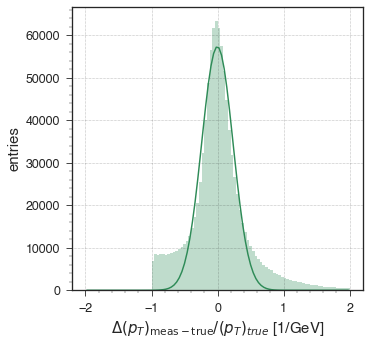

[INFO    ] # of entries: 150180, mean: 0.196804929838367, std: 9.944744713281992
INFO:pruning_test:# of entries: 150180, mean: 0.196804929838367, std: 9.944744713281992
[INFO    ] gaus fit (a, mu, sig): [9.97171939e+03 2.93232808e-01 5.43318692e+00]
INFO:pruning_test:gaus fit (a, mu, sig): [9.97171939e+03 2.93232808e-01 5.43318692e+00]


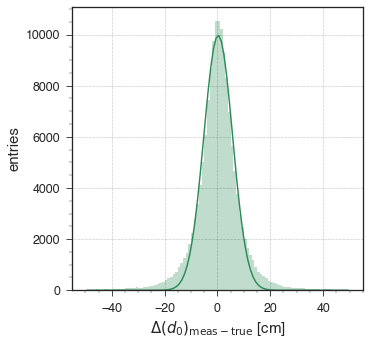

In [11]:
__generate_delta_plots__(pruned_qmodel,
                         x = x_test_displ,
                         y = y_test_displ,
                         dxy = dxy_test_displ,
                         color = "seagreen")